<h1 style="text-align:center;font-size:30px;line-height:40px">
Bank Churner Analysis
</h1>

In [1]:
from IPython.display import HTML, Markdown

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%%html
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
};
</style>

In [3]:
sns_theme = sns.diverging_palette(20,240,100,60)
sns_cmap_theme = sns.diverging_palette(20,240,100,60, as_cmap=True)

pd.set_option('display.max_columns', 50)

# Import data

**Data source:** [Kaggle](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)

<p><mark style="background-color:pink;font-weight:bold">Business Problem:</mark> A bank manager is uncomfortable with more and more customers leaving their credit card services. They would really appreciate it if someone could predict who will be affected so that they can proactively go to the customer to provide them with better services and turn customer decisions in the opposite direction.</p>

<p><mark style="background-color:lime;font-weight:bold">Goal:</mark> Conduct an analysis to understand the behavior of the customers and find out which variables indicate a strong relationship with the cancellation of credit card service</p>

**Dataset preview**

In [2]:
bank_df = pd.read_csv("BankChurners.csv")
bank_df.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
154,795232683,Existing Customer,53,F,1,College,Married,Less than $40K,Blue,47,...,2154.0,930,1224.0,2.121,1439,26,1.364,0.432,0.000175,0.99983
1702,799249833,Existing Customer,34,M,2,Graduate,Single,Less than $40K,Blue,28,...,4439.0,844,3595.0,0.863,2858,71,0.690,0.190,0.000158,0.99984
762,714665733,Existing Customer,42,M,4,Graduate,Single,$60K - $80K,Blue,36,...,2727.0,834,1893.0,0.568,1294,26,0.444,0.306,0.000021,0.99998
6143,789122808,Attrited Customer,41,F,4,College,Married,$40K - $60K,Blue,29,...,3281.0,0,3281.0,0.875,2907,45,0.406,0.000,0.994900,0.00510
2040,713108433,Existing Customer,53,M,3,College,Married,$80K - $120K,Blue,40,...,6052.0,1720,4332.0,0.683,1476,37,0.423,0.284,0.000629,0.99937


<mark style="background-color:cyan;font-weight:bold">About the dataset:</mark> The dataset consists of 10127 data points with demographic and behavioral information of customers. There're **16.07%** of the data is customers who have canceled their credit cards

<mark style="background-color:#C09FFA;font-weight:bold">Feature descriptions:</mark>
- **Attrition_Flag:** Our target variable. Show us whether customer decided to stop using company's credit card service
- **Dependent_count:** Number of depedents
- **Income_Category:** Annual Income Category. There are 6 categories including (<\\$40K, \\$40K-60K, \\$60K-\\$80K, \\$80K-\\$120K, >\\$120K, Unknown)
- **Card_Category:** There 4 types of card (Blue, Silver, Gold, Platinum)
- **Months_on_book:** Period of relationship with bank
- **Months_Inactive:** amount of inactivity when using the credit card
- **Total_Revolving_Bal:** The unpaid portion that carries over to the next month when a customer does not pay
- **Avg_Utilization_Ratio:** Measures the average of how much credit you are using compared to how much you have available
- **Avg_Open_to_Buy:** The amount of credit available at a given time on a credit card holders account. Thus, the average open to buy is the average credit available allocated to a specific customer.

# Clean Data 

This data is well-cleaned so here I will:
- Drop the 2 last columns according to the data publisher
- Rename some columns to be more clear
- Map the values of the dependent variable `Attrition_Flag` to 0 (Existing Customer) and 1 (Attrited Customer)

In [6]:
dropped_columns = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
drop_2_last_df = bank_df.drop(dropped_columns, axis=1)

rename_columns = {
    'Contacts_Count_12_mon': 'Contacts_Count_12_month',
    'Months_Inactive_12_mon': 'Months_Inactive_12_month',
    'Total_Revolving_Bal': 'Total_Revolving_Balance',
    'Total_Amt_Chng_Q4_Q1': 'Total_Amt_Change_Q4_Q1',
    'Total_Ct_Chng_Q4_Q1': 'Total_Count_Change_Q4_Q1',
    'Total_Trans_Amt': 'Total_Transaction_Amt',
    'Total_Trans_Ct': 'Total_Transaction_Count',
}
renamed_df = drop_2_last_df.rename(columns=rename_columns)

categorical_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
edu_cat = pd.CategoricalDtype(
    ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    ordered=True
)
renamed_df['Education_Level'] = renamed_df['Education_Level'].astype(edu_cat)

income_cat = pd.CategoricalDtype(
    ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
    ordered=True
)
renamed_df['Income_Category'] = renamed_df['Income_Category'].astype(income_cat)

card_cat = pd.CategoricalDtype(
    ['Blue', 'Silver', 'Gold', 'Platinum'],
    ordered=True
)
renamed_df['Card_Category'] = renamed_df['Card_Category'].astype(card_cat)

renamed_df['Gender'] = renamed_df['Gender'].astype('category')
renamed_df['Marital_Status'] = renamed_df['Marital_Status'].astype('category')


renamed_df['Attrition_Flag'] = (renamed_df['Attrition_Flag'] != 'Existing Customer').astype(int)
label_map = {
    0: 'Existing Customers',
    1: 'Attrited Customers'
}
cleaned_df = renamed_df.copy()

# Exploratory Data Analysis

## Quantitative variables

We first take a look at the statistics of quantitative variables  and their distributions

In [36]:
id_columns = ['CLIENTNUM']
numeric_columns_summary_df = cleaned_df.drop(id_columns + categorical_columns, axis=1).describe().T
numeric_columns = numeric_columns_summary_df.index.values
display(numeric_columns_summary_df)

,count,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127.0,0.160660,0.367235,0.0,0.000,0.000,0.000,1.000
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_month,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_month,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Balance,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000


---

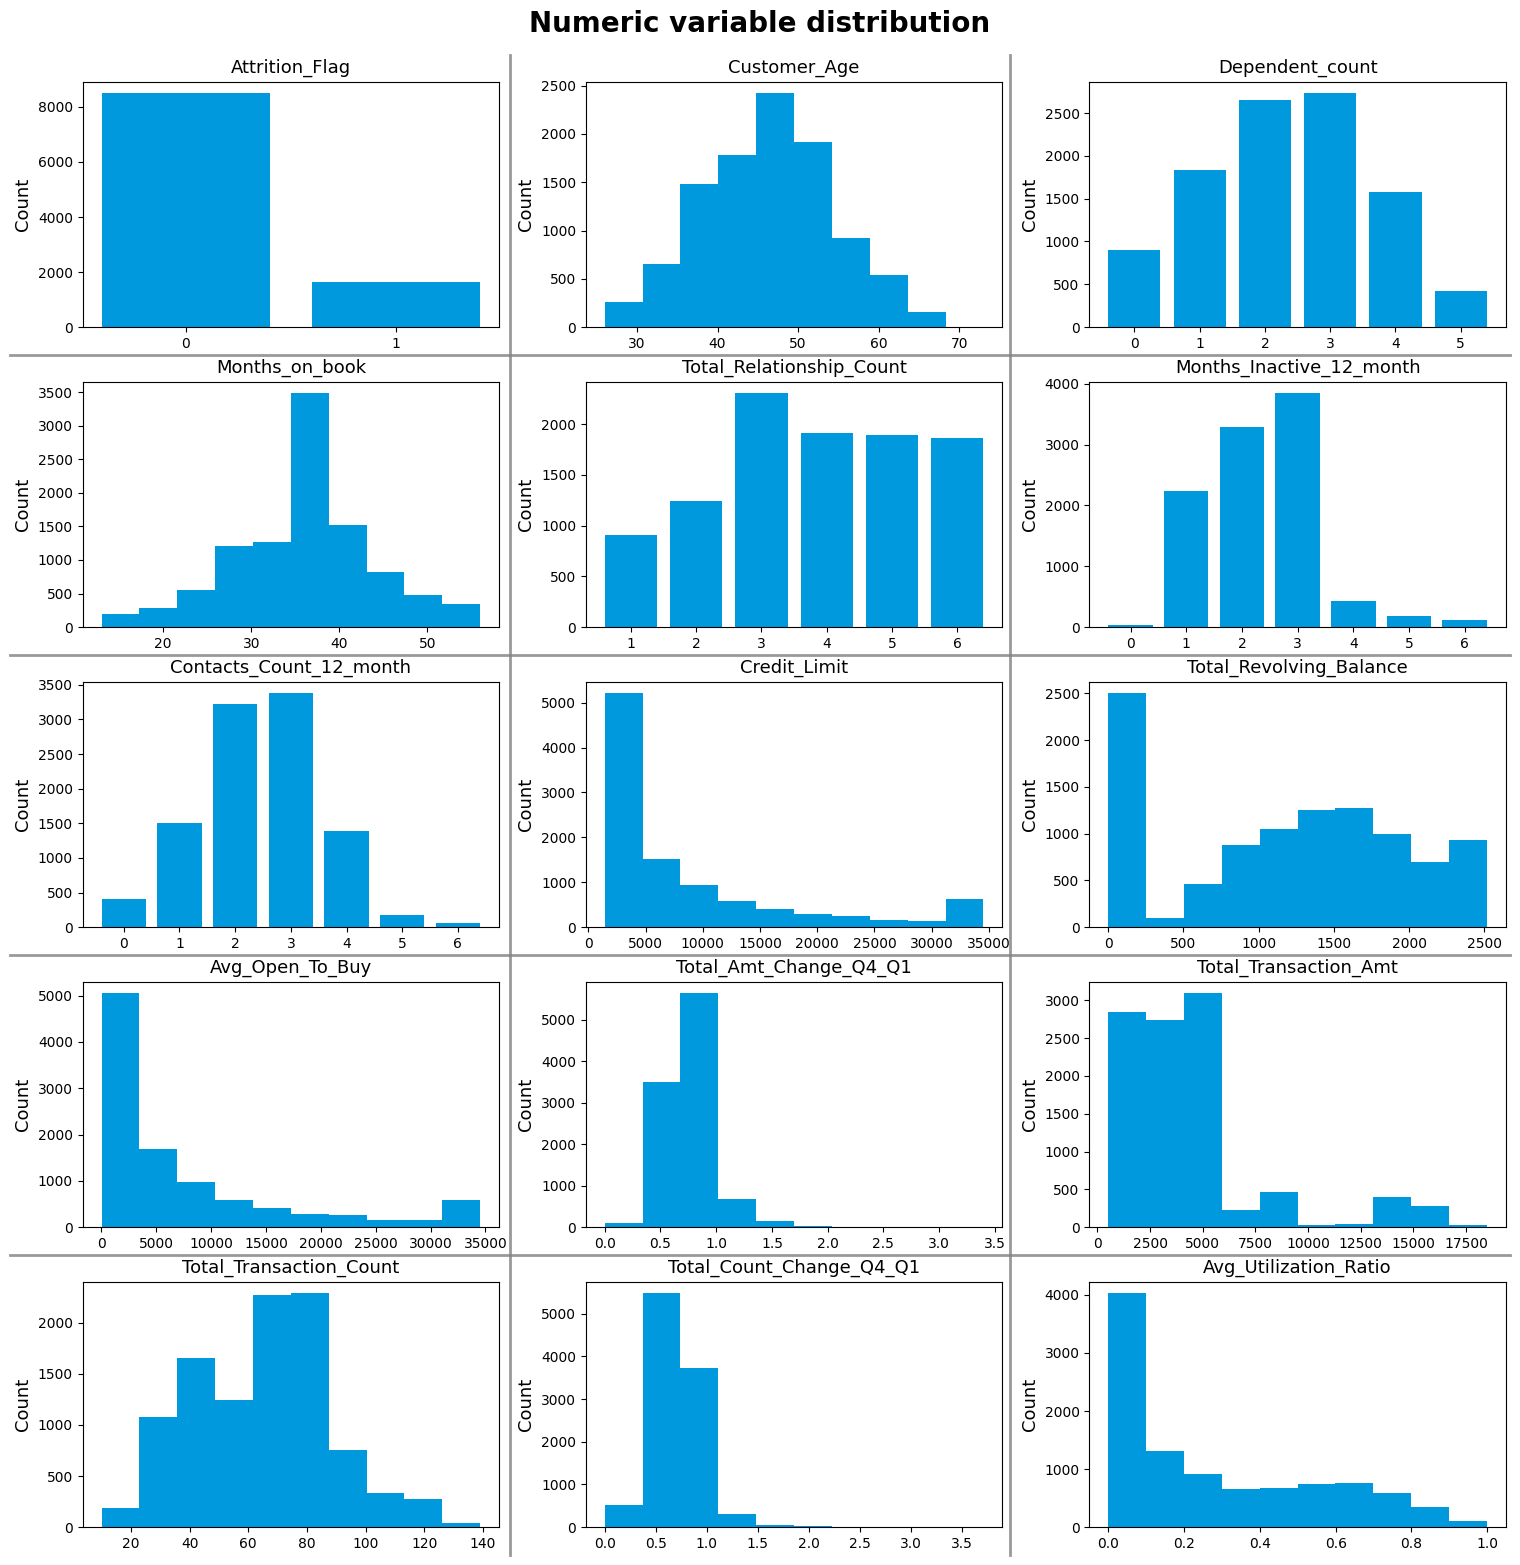

In [9]:
ax_width = 5
ax_height = 3
n_cols = 3
n_rows = 5
label_style = {'size':13}
fig = plt.figure(figsize=(n_cols*(ax_width), n_rows*(ax_height)), layout='constrained',)
fig.suptitle('Numeric variable distribution', size=20, weight='bold', y=1.03)
for ax_idx, plotted_col in enumerate(numeric_columns, 1):
    ax = plt.subplot(n_rows, n_cols, ax_idx)
    if cleaned_df[plotted_col].nunique() > 10:
        ax.hist(cleaned_df[plotted_col], color=sns_theme[-1])
    else:
        count_df = cleaned_df[plotted_col].value_counts()
        ax.bar(x=count_df.index, height=count_df, color=sns_theme[-1])
        if plotted_col == 'Attrition_Flag':
            ax.set_xticks([0,1])
    ax.set_title(f'{plotted_col}', fontdict=label_style)
    ax.set_ylabel('Count', fontdict=label_style)

x_vlines = np.linspace(0,1,n_cols+1)[1:-1]
fixed_coord_value =[0, 1]
y_hlines = np.linspace(0,1,n_rows+1)[1:-1]
for x in x_vlines: # Vertical lines
    plt.plot([x]*2, fixed_coord_value, lw=2, color='gray', alpha=0.8, transform=plt.gcf().transFigure, clip_on=False)
for y in y_hlines: # Horizontal lines
    plt.plot(fixed_coord_value, [y]*2, lw=2, color='gray', alpha=0.8, transform=plt.gcf().transFigure, clip_on=False)

gc.collect()
plt.show()

---

To keep this analysis simple, I will start from calculating spearman's correlation which is a measurement of dependence between 2 variables. The results will help us to narrow down the number of variables we should investigate.

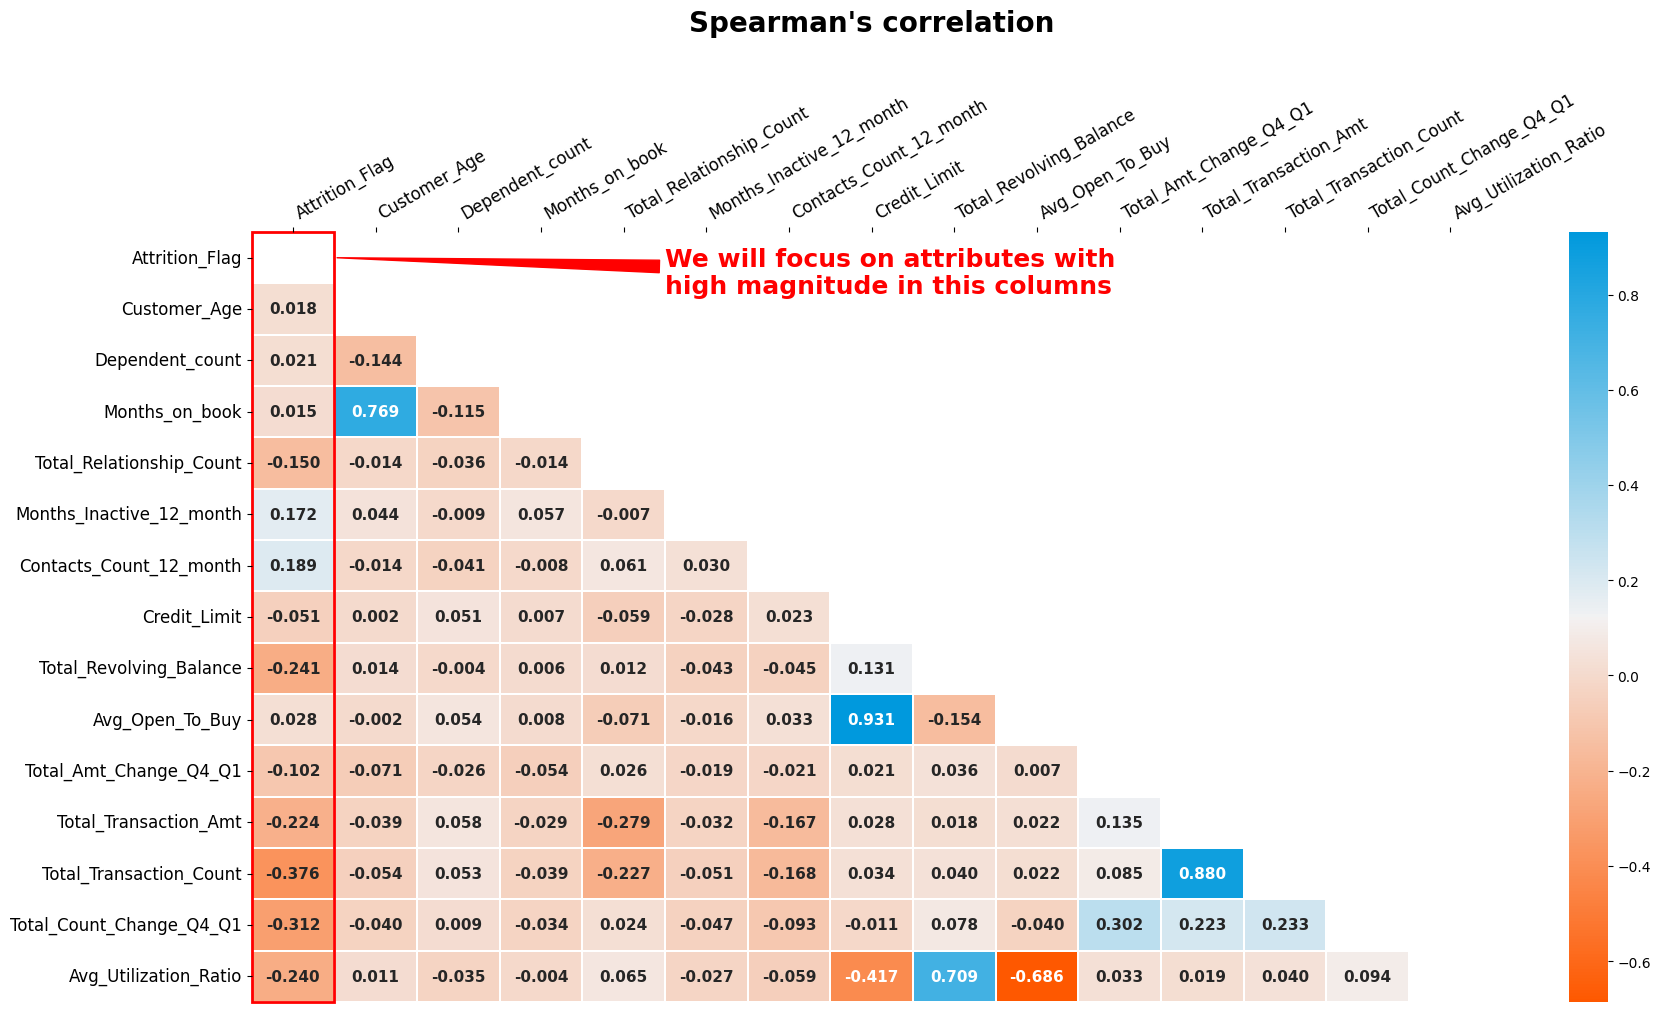

In [275]:
fig = plt.figure(figsize=(20,10))

corr_df = cleaned_df[numeric_columns].corr(method='spearman')
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap=sns_cmap_theme,\
            linewidths=0.2, annot_kws={'size':11, 'weight':'semibold'}, mask=np.triu(np.ones(corr_df.shape)))

ax = plt.gca()
ax.set_title("Spearman's correlation", fontdict={'size':20, 'weight':'bold'}, y=1.25)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontdict={'size':12,'horizontalalignment':'left'})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':12})

rect = patches.Rectangle((0, 0), 1, 15, linewidth=2, edgecolor='r', facecolor='none',clip_on=False)
ax.add_patch(rect)
ax.annotate('We will focus on variables with\ngreat magnitude in this columns', (1, 0.5), (5, 1.2),
            arrowprops={
                'arrowstyle':patches.ArrowStyle('wedge', tail_width=0.5),
                'facecolor':'red',
                'edgecolor':'red',
            },
            fontsize=18,
            fontweight='bold',
            color='red'
)

gc.collect()
plt.show()

Look at the correlation table, some variables show a negative association to the dependent variable such as `Total_Transaction_Count`, `Total_Transaction_Amt`, `Total_Count_Change_Q4_Q1`, `Avg_Utilization_Ratio` (We omit the `Total_Revolving_Balance` because `Avg_Utilization_Ratio` is calculated from it, so we use either)

Regarding the positive association variables, we have `Months_Inactive_12_month`, `Contacts_Count_12_month`

$\Rightarrow$ So here we will visualize the distribution of these variables for existing customers and attrited customers. Then, we compare them to determine any noteworthy characteristics

## Customer behavior analysis 

In [7]:
focused_columns = ['Total_Transaction_Count', 'Total_Transaction_Amt', 'Total_Revolving_Balance', 'Avg_Utilization_Ratio', 'Months_Inactive_12_month', 'Contacts_Count_12_month']
tmp_df = cleaned_df.groupby('Attrition_Flag')[focused_columns].median()

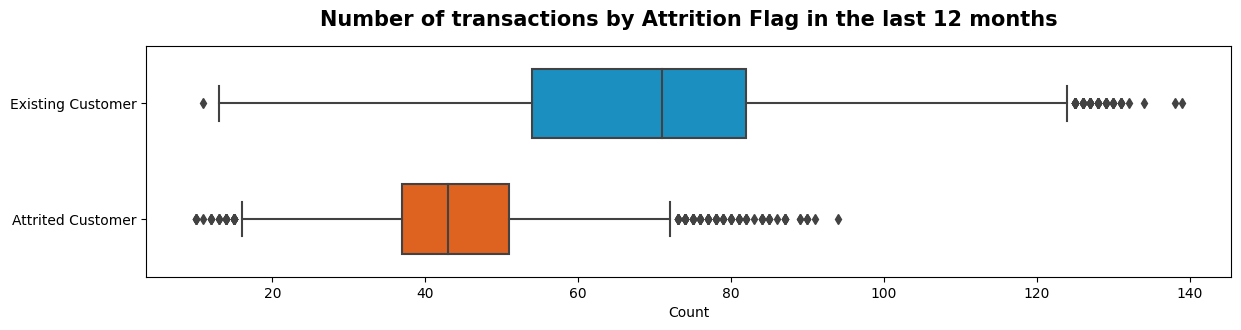

In [113]:
plotted_variable = 'Total_Transaction_Count'
fig = plt.figure(figsize=(14,3))
ax = sns.boxplot(x=cleaned_df[plotted_variable], y=cleaned_df['Attrition_Flag'].astype('category'),\
                 palette=[sns_theme[-1], sns_theme[0]], width=0.6)
ax.set_yticklabels(['Existing Customer', 'Attrited Customer'])
ax.set_title('Number of transactions by Attrition Flag in the last 12 months', fontsize=15, fontweight='bold', y=1.05)
ax.set_ylabel('')
ax.set_xlabel('Count')
plt.show()

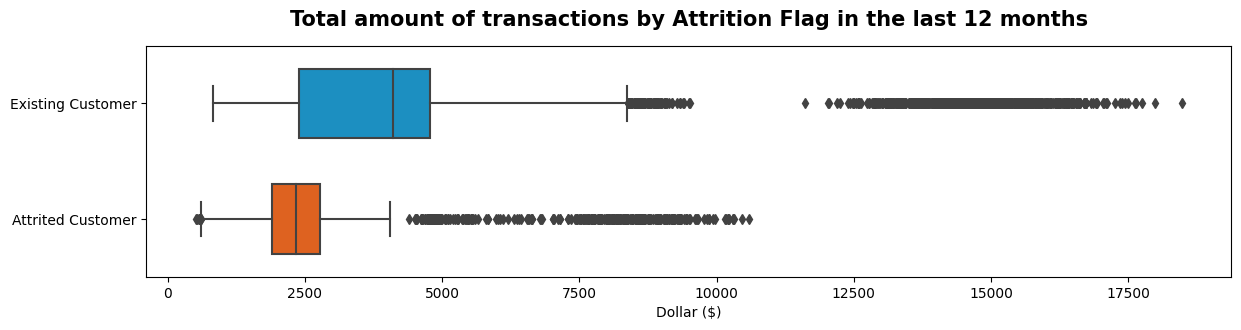

In [114]:
plotted_variable = 'Total_Transaction_Amt'
fig = plt.figure(figsize=(14,3))
ax = sns.boxplot(x=cleaned_df[plotted_variable], y=cleaned_df['Attrition_Flag'].astype('category'),\
                 palette=[sns_theme[-1], sns_theme[0]], width=0.6)
ax.set_yticklabels(['Existing Customer', 'Attrited Customer'])
ax.set_title('Total amount of transactions by Attrition Flag in the last 12 months', fontsize=15, fontweight='bold', y=1.05)
ax.set_ylabel('')
ax.set_xlabel('Dollar ($)')
plt.show()

- **Attrited Customers** tend to make **fewer transactions** than those who not
- **Attrited customers** spend **less amount of credit than Existing customers** on the average
- There's a group of customers that have an especially **high total amount of transactions in a year (above \\$11K)** doesn't churn

---

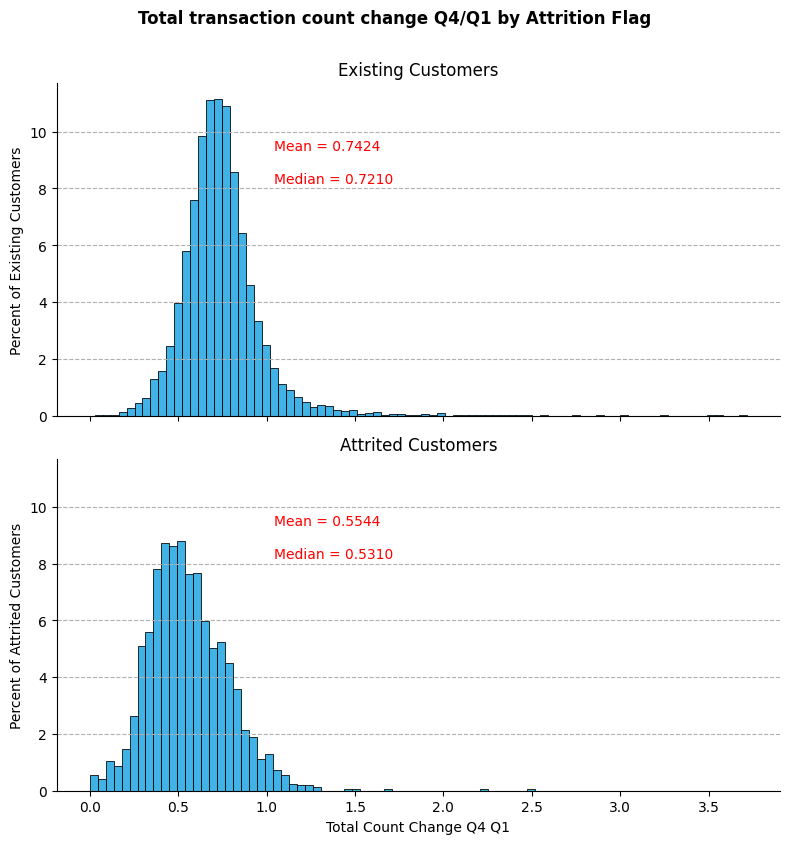

In [82]:
display_df = cleaned_df.groupby(cleaned_df['Attrition_Flag'].astype('category'))['Total_Count_Change_Q4_Q1'].describe()

plotted_variable = 'Total_Count_Change_Q4_Q1'
g = sns.FacetGrid(data=cleaned_df, row='Attrition_Flag', sharex=True, height=4, aspect=2)
g.map(sns.histplot, plotted_variable, stat='percent', binwidth=0.045, color=sns_theme[-1])
for idx, ax in enumerate(g.axes.squeeze()):
    ax.set_title('Attrited Customers' if idx else 'Existing Customers')
    ax.set_ylabel(f"Percent of {'Attrited Customers' if idx else 'Existing Customers'}")
    ax.grid(axis='y', linestyle='--')
    ax.annotate(f"Mean = {display_df.loc[idx, 'mean']:.4f}", xy=(0.3, 0.8), xycoords='axes fraction', color='red')
    ax.annotate(f"Median = {display_df.loc[idx, '50%']:.4f}", xy=(0.3, 0.7), xycoords='axes fraction', color='red')
    
ax.set_xlabel(f"{plotted_variable.replace('_', ' ')}")
g.fig.suptitle('Total transaction count change Q4/Q1 by Attrition Flag', fontweight='bold', y=1.05)
plt.show()

- On average, the **number of transactions** made by **Existing customers in Q1 is more than in Q4** by **above 70%**, while this figure for **Attrited customers is around 55%**. Given that, it suggests customers might have encountered some problems when making transactions with high frequency

---

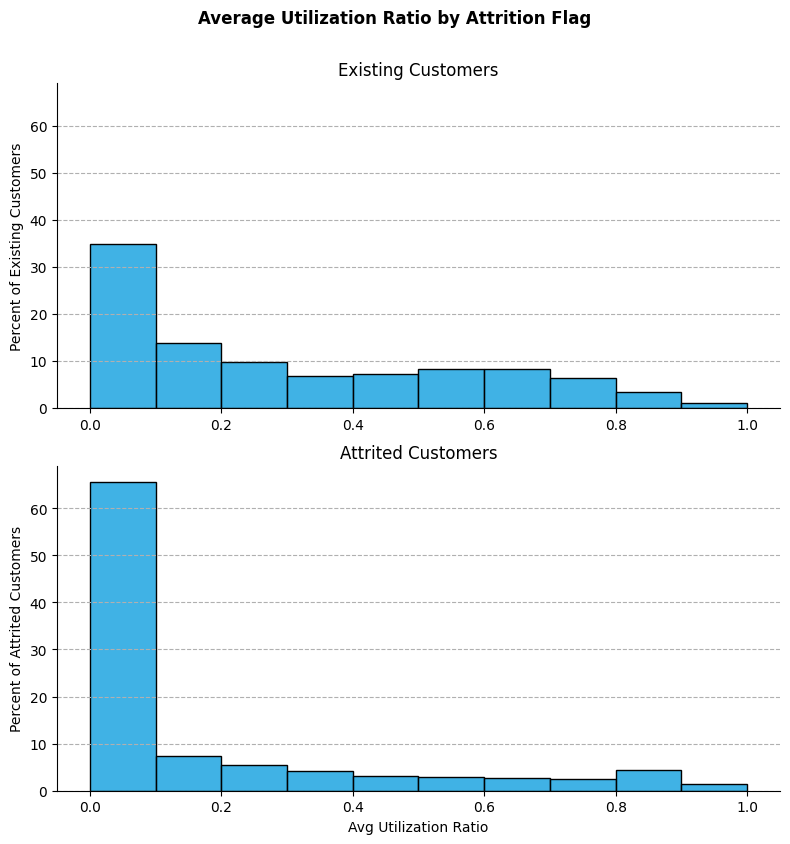

In [83]:
plotted_variable = 'Avg_Utilization_Ratio'
g = sns.FacetGrid(data=cleaned_df, row='Attrition_Flag', sharex=False, height=4, aspect=2)
g.map(sns.histplot, plotted_variable, stat='percent', binwidth=0.1, color=sns_theme[-1])
for idx, ax in enumerate(g.axes.squeeze()):
    ax.set_title('Attrited Customers' if idx else 'Existing Customers')
    ax.set_ylabel(f"Percent of {'Attrited Customers' if idx else 'Existing Customers'}")
    ax.grid(axis='y', linestyle='--')
ax.set_xlabel(f"{plotted_variable.replace('_', ' ')}")
g.fig.suptitle('Average Utilization Ratio by Attrition Flag', fontweight='bold', y=1.05)
plt.show()

- About **35% of existing customers** have an average utilization ratio of less than 0.1, and this figure for **Attrited customers is about 65%**. Regarding other utilization ratio values, existing customers are virtually higher than attrited customers. Therefore, we can conclude that customers canceled their credit cards because they didn't use or couldn't effectively utilize them while they had to pay for related fee

---

In [19]:
def to_percent_by_attrition_flag(df, group_col, count_col):
    return (
        df.groupby(group_col)[count_col]\
        .value_counts(normalize=True)\
        .mul(100)\
        .rename('Percent')\
        .reset_index(),
        df.groupby(count_col)[group_col]\
        .value_counts(normalize=True)\
        .mul(100)\
        .rename('Percent')\
        .reset_index()
    )

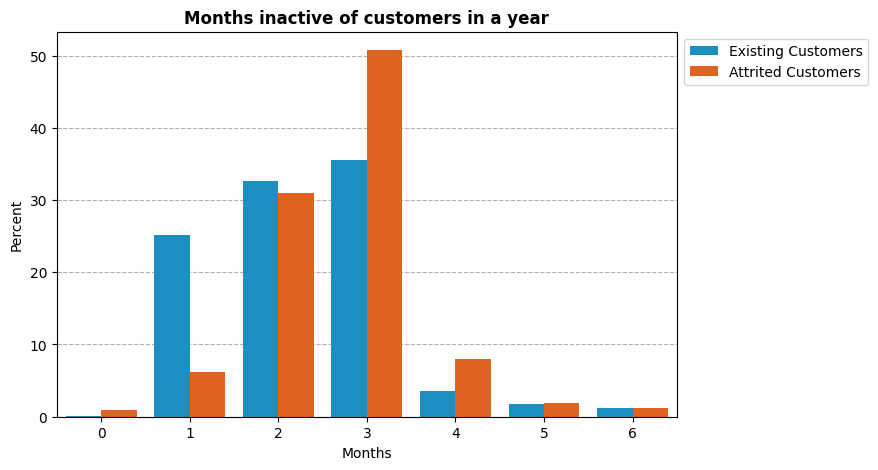

In [29]:
count_df, _= to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', 'Months_Inactive_12_month')
count_df['Attrition_Flag'] = count_df['Attrition_Flag'].map(label_map)

fig=plt.figure(figsize=(8,5))
sns.barplot(
    data=count_df,
    x='Months_Inactive_12_month',
    y='Percent',
    hue='Attrition_Flag',
    palette=[sns_theme[-1], sns_theme[0]]
)
ax = plt.gca()
ax.set_title('Months inactive of customers in a year', fontweight='bold')
ax.legend(bbox_to_anchor=(1.32, 1))
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
ax.set_xlabel('Months')
plt.show()

- More than 50% of Attrited customers have the inactive time of 3 months. 
- On average, the time being inactive of Attrited customers is longer Existing customers

---

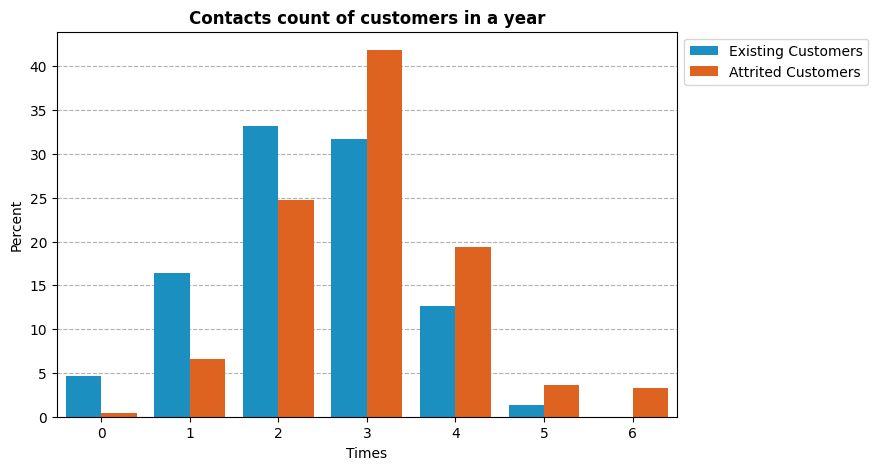

In [28]:
count_df, _ = to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', 'Contacts_Count_12_month')
count_df['Attrition_Flag'] = count_df['Attrition_Flag'].map(label_map)

fig=plt.figure(figsize=(8,5))
sns.barplot(
    data=count_df,
    x='Contacts_Count_12_month',
    y='Percent',
    hue='Attrition_Flag',
    palette=[sns_theme[-1], sns_theme[0]]
)
ax = plt.gca()
ax.set_title('Contacts count of customers in a year', fontweight='bold')
ax.legend(bbox_to_anchor=(1.32, 1))
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
ax.set_xlabel('Times')
plt.show()

- This chart demonstrates that Attrited customers have contacted the bank more than Existing customers. Probably, customers who canceled credit cards might have encountered problems during the use of the service that hasn't been satisfactorily resolved.

---

Summary of the charts below:
- Both Existing customers and Attrited customers have similar distributions on all qualitative fields
- `Graduate` is the most common education level of customers. The largest group of attrited customers is `Graduate` accounting for **29.93%**, and the smallest is `Post-Graduate` with **5.65%**. Inspecting the attrition ratio of different groups, all are **below 20%** except `Doctorate` accounting for **21.06%**
- `Less than $40K` is the most common income category of customers. The largest group of attrited customers is `Less than $40K` accounting for **37.62%**, and the smallest is `$120K+` with **7.74%**. The attrition ratio between different groups don't have any abnormal statistics
- `Married` is the most common marital status of customers. The largest group of attrited customers is `Married` accounting for **43.58%**, and the smallest is `Divorced` with **7.44%**. The attrition ratio between different groups don't have any abnormal statistics
- `Blue` is the most common income category of customers. The largest group of attrited customers is `Blue` accounting for **93.36%**, and the smallest is `Platinum` with **0.31%**. Inspecting the attrition ratio of different groups, all are **below 20%** except `Platinum` accounting for **25%**, however, the figure is not statistically significant because there are only 20 platinum card customers in total

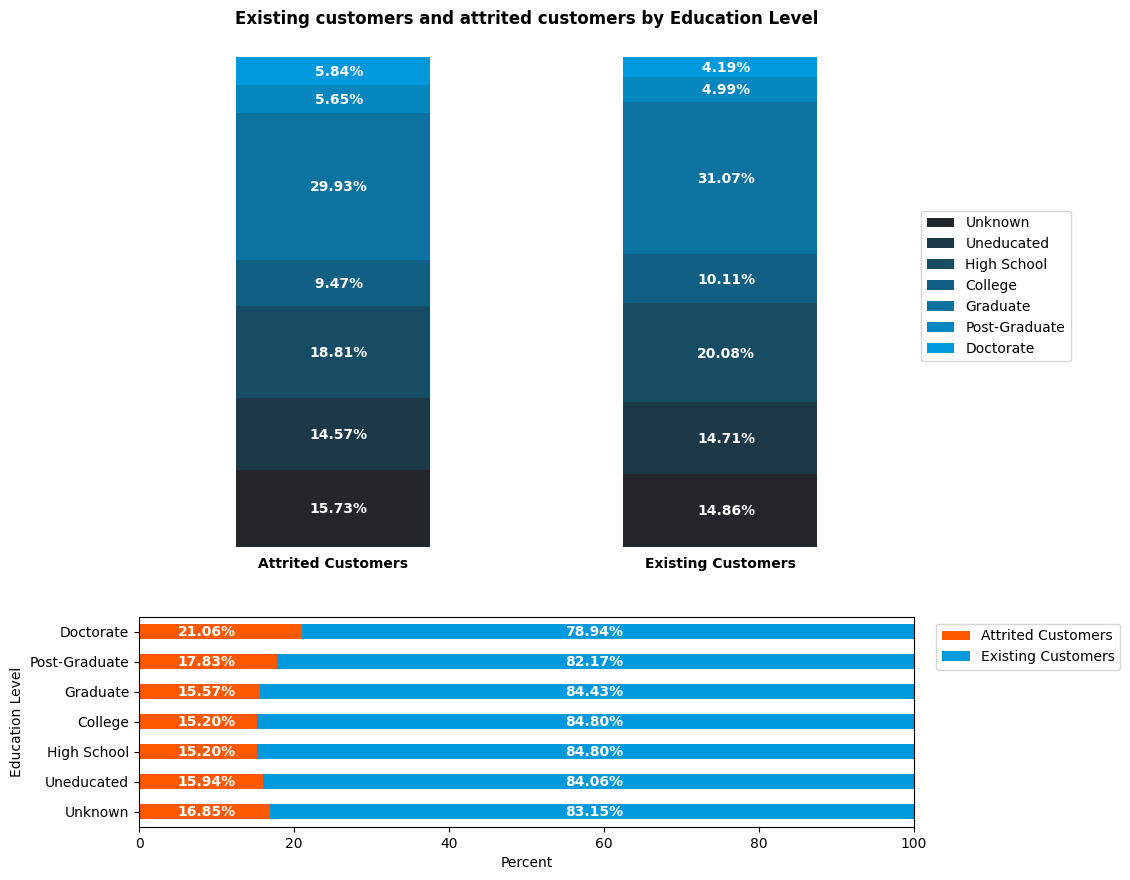

In [124]:
plotted_variable = 'Education_Level'
plot1_df, plot2_df = to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', plotted_variable)
plot1_df['Attrition_Flag'] = plot1_df['Attrition_Flag'].map(label_map)
plot2_df['Attrition_Flag'] = plot2_df['Attrition_Flag'].map(label_map)

pivot_df = plot1_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
rename_col_map = list(map(lambda x: x[1], pivot_df.columns))
pivot_df.columns = rename_col_map
pivot_df = pivot_df.T

fig, axs = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[7,3])
pivot_df.plot.bar(
    stacked=True,
    color=sns.dark_palette(
        sns_theme[-1],
        n_colors=cleaned_df[plotted_variable].nunique()
    ),
    ax = axs[0]
)
for patch in axs[0].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[0].annotate(f'{height:5.2f}%', (x+width*0.38, y+max(height-2, 0)*0.5), fontweight='bold', color='white')
axs[0].set_ylim(top=100)
axs[0].legend(bbox_to_anchor=(1, 0.7))
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=0, fontweight='bold')
axs[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[0].xaxis.set_ticks_position('none')
axs[0].set_title(
    f'Existing customers and attrited customers by {plotted_variable.replace("_", " ")}',
    fontweight='bold',
    y=1.05
)

pivot_df = plot2_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
pivot_df.columns = rename_col_map

pivot_df.plot.barh(
    stacked=True,
    ax = axs[1],
    color=[sns_theme[0], sns_theme[-1]]
)
axs[1].set_xlim(right=100)
axs[1].legend(bbox_to_anchor=(1.02, 1))
axs[1].set_ylabel(plotted_variable.replace('_', ' '))
axs[1].set_xlabel('Percent')

for patch in axs[1].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[1].annotate(f'{width:5.2f}%', (5 if width<30 else 55, y+0.1), fontweight='bold', color='white')

plt.show()

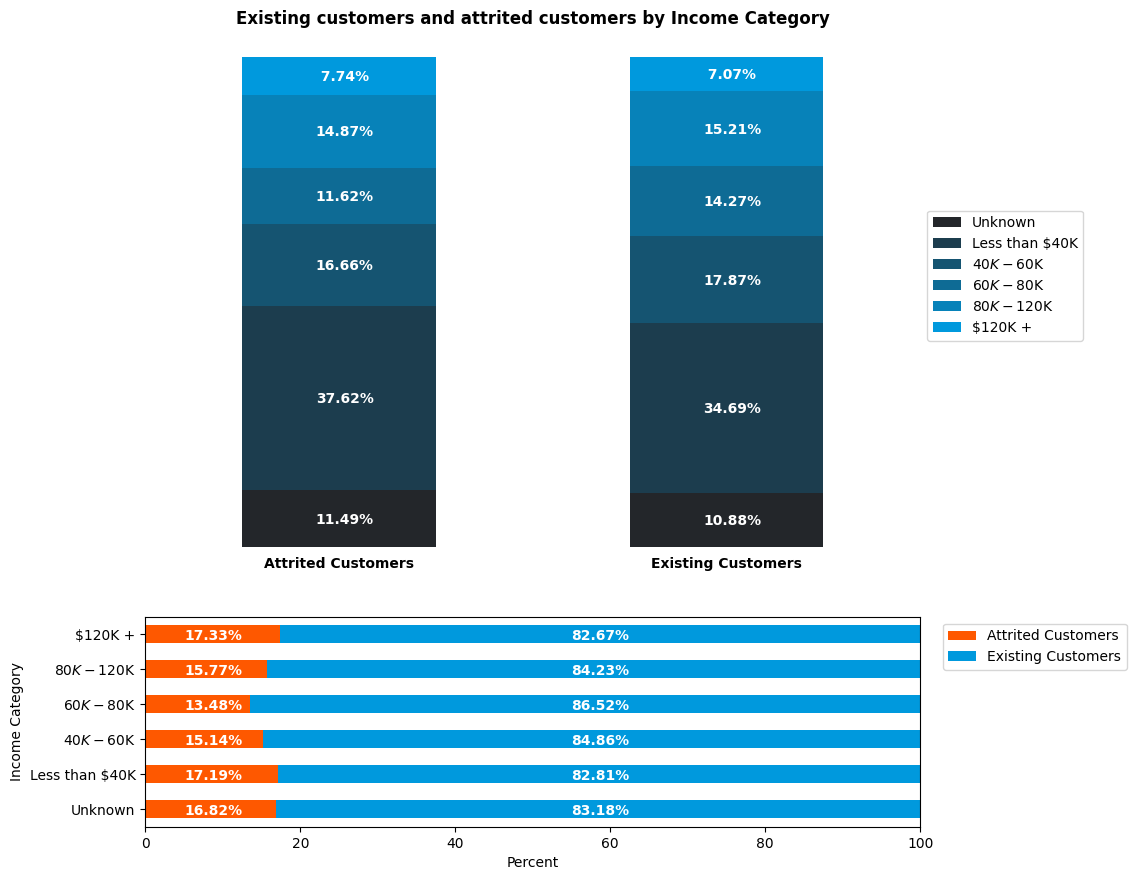

In [125]:
plotted_variable = 'Income_Category'
plot1_df, plot2_df = to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', plotted_variable)
plot1_df['Attrition_Flag'] = plot1_df['Attrition_Flag'].map(label_map)
plot2_df['Attrition_Flag'] = plot2_df['Attrition_Flag'].map(label_map)

pivot_df = plot1_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
rename_col_map = list(map(lambda x: x[1], pivot_df.columns))
pivot_df.columns = rename_col_map
pivot_df = pivot_df.T

fig, axs = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[7,3])
pivot_df.plot.bar(
    stacked=True,
    color=sns.dark_palette(
        sns_theme[-1],
        n_colors=cleaned_df[plotted_variable].nunique()
    ),
    ax = axs[0]
)
for patch in axs[0].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[0].annotate(f'{height:5.2f}%', (x+width*0.38, y+max(height-2, 0)*0.5), fontweight='bold', color='white')
axs[0].set_ylim(top=100)
axs[0].legend(bbox_to_anchor=(1, 0.7))
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=0, fontweight='bold')
axs[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[0].xaxis.set_ticks_position('none')
axs[0].set_title(
    f'Existing customers and attrited customers by {plotted_variable.replace("_", " ")}',
    fontweight='bold',
    y=1.05
)

pivot_df = plot2_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
pivot_df.columns = rename_col_map

pivot_df.plot.barh(
    stacked=True,
    ax = axs[1],
    color=[sns_theme[0], sns_theme[-1]]
)
axs[1].set_xlim(right=100)
axs[1].legend(bbox_to_anchor=(1.02, 1))
axs[1].set_ylabel(plotted_variable.replace('_', ' '))
axs[1].set_xlabel('Percent')

for patch in axs[1].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[1].annotate(f'{width:5.2f}%', (5 if width<20 else 55, y+0.1), fontweight='bold', color='white')

plt.show()

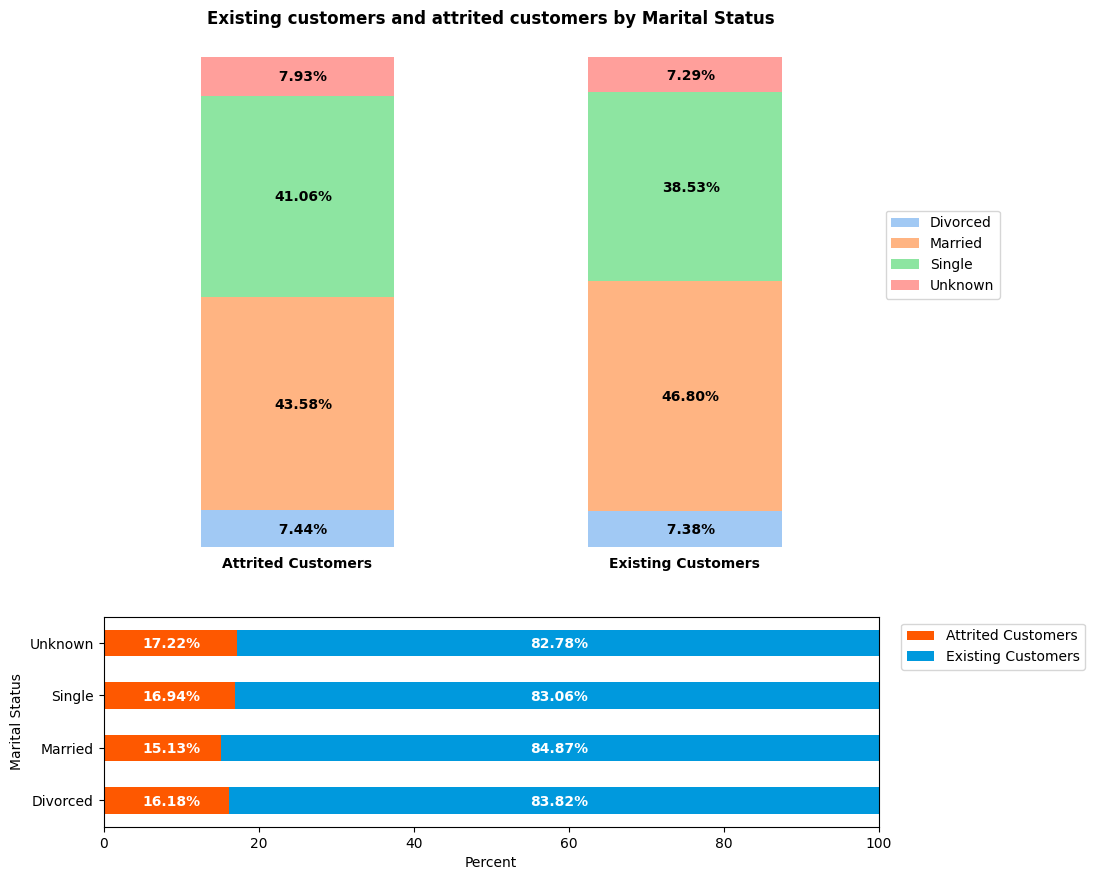

In [126]:
plotted_variable = 'Marital_Status'
plot1_df, plot2_df = to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', plotted_variable)
plot1_df['Attrition_Flag'] = plot1_df['Attrition_Flag'].map(label_map)
plot2_df['Attrition_Flag'] = plot2_df['Attrition_Flag'].map(label_map)

pivot_df = plot1_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
rename_col_map = list(map(lambda x: x[1], pivot_df.columns))
pivot_df.columns = rename_col_map
pivot_df = pivot_df.T

fig, axs = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[7, 3])
pivot_df.plot.bar(
    stacked=True,
    color=sns.color_palette('pastel'),
    ax = axs[0]
)
for patch in axs[0].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[0].annotate(f'{height:5.2f}%', (x+width*0.38, y+max(height-2, 0)*0.5), fontweight='bold', color='black')
axs[0].set_ylim(top=100)
axs[0].legend(bbox_to_anchor=(1, 0.7))
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=0, fontweight='bold')
axs[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[0].xaxis.set_ticks_position('none')
axs[0].set_title(
    f'Existing customers and attrited customers by {plotted_variable.replace("_", " ")}',
    fontweight='bold',
    y=1.05
)

pivot_df = plot2_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
pivot_df.columns = rename_col_map

pivot_df.plot.barh(
    stacked=True,
    ax = axs[1],
    color=[sns_theme[0], sns_theme[-1]]
)
axs[1].set_xlim(right=100)
axs[1].legend(bbox_to_anchor=(1.02, 1))
axs[1].set_ylabel(plotted_variable.replace('_', ' '))
axs[1].set_xlabel('Percent')

for patch in axs[1].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[1].annotate(f'{width:5.2f}%', (5 if width<20 else 55, y+0.15), fontweight='bold', color='white')

plt.show()

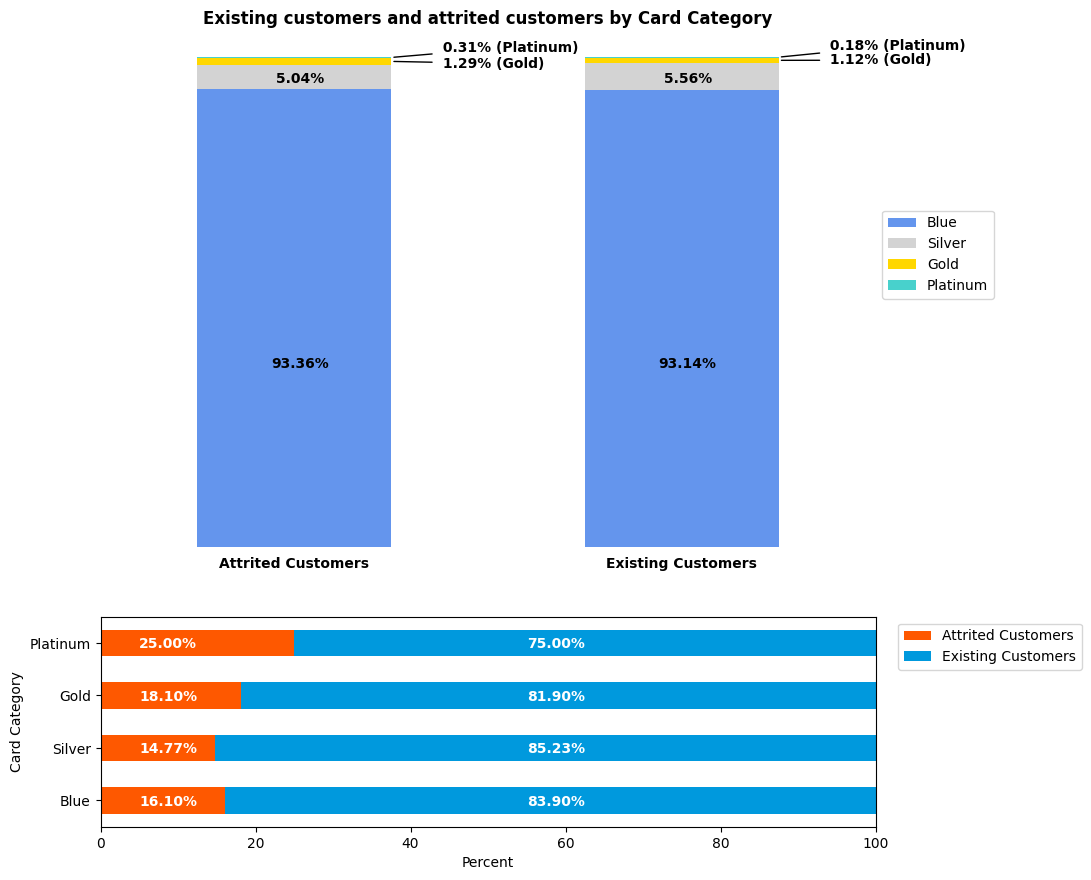

In [53]:
plotted_variable = 'Card_Category'
plot1_df, plot2_df = to_percent_by_attrition_flag(cleaned_df, 'Attrition_Flag', plotted_variable)
plot1_df['Attrition_Flag'] = plot1_df['Attrition_Flag'].map(label_map)
plot2_df['Attrition_Flag'] = plot2_df['Attrition_Flag'].map(label_map)

pivot_df = plot1_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
rename_col_map = list(map(lambda x: x[1], pivot_df.columns))
pivot_df.columns = rename_col_map
pivot_df = pivot_df.T

fig, axs = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[7, 3])
pivot_df.plot.bar(
    stacked=True,
    color=['cornflowerblue', 'lightgray', 'gold', 'mediumturquoise'],
    ax = axs[0]
)
categories_order = cleaned_df['Card_Category'].cat.categories
for idx, patch in enumerate(axs[0].patches):
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    if height < 3:
        axs[0].annotate(
            f'{height:5.2f}% ({categories_order[idx//2]})', (x+width, y+height/2),
            (x+width+0.12, y+2-height*2), 
            fontweight='bold', arrowprops={'arrowstyle':patches.ArrowStyle('-')},
            color='black',
        )
    else:
        axs[0].annotate(f'{height:5.2f}%', (x+width*0.38, y+max(height-2, 0)*0.4), fontweight='bold', color='black')
axs[0].set_ylim(top=100)
axs[0].legend(bbox_to_anchor=(1, 0.7))
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=0, fontweight='bold')
axs[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[0].xaxis.set_ticks_position('none')
axs[0].set_title(
    f'Existing customers and attrited customers by {plotted_variable.replace("_", " ")}',
    fontweight='bold',
    y=1.05
)

pivot_df = plot2_df.pivot_table(values=['Percent'], index=[plotted_variable], columns=['Attrition_Flag'])
pivot_df.columns = rename_col_map

pivot_df.plot.barh(
    stacked=True,
    ax = axs[1],
    color=[sns_theme[0], sns_theme[-1]]
)
axs[1].set_xlim(right=100)
axs[1].legend(bbox_to_anchor=(1.02, 1))
axs[1].set_ylabel(plotted_variable.replace('_', ' '))
axs[1].set_xlabel('Percent')

for patch in axs[1].patches:
    x, y = patch.get_xy()
    height, width = patch.get_height(), patch.get_width()
    axs[1].annotate(f'{width:.2f}%', (5 if width<30 else 55, y+0.15), fontweight='bold', color='white')

plt.show()

---

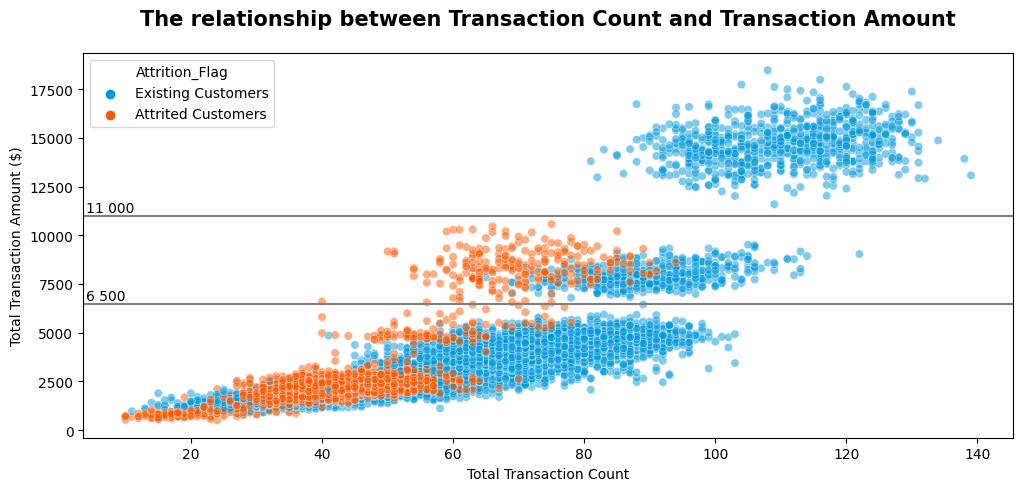

In [58]:
fig = plt.figure(figsize=(12,5))
plot_df = cleaned_df.copy()
plot_df['Attrition_Flag'] = plot_df['Attrition_Flag'].map(label_map)
sns.scatterplot(
    data=plot_df, 
    x='Total_Transaction_Count', 
    y='Total_Transaction_Amt', 
    hue='Attrition_Flag', 
    palette=[sns_theme[-1], sns_theme[0]],
    alpha=0.5
)
ax = plt.gca()
ax.set_xlabel('Total Transaction Count')
ax.set_ylabel('Total Transaction Amount ($)')
ax.set_title('The relationship between Transaction Count and Transaction Amount', fontsize=15, fontweight='bold', y=1.05)
ax.axhline(y=6500, color='gray')
ax.annotate('6 500', xy=(4, 6700))
ax.axhline(y=11000, color='gray')
ax.annotate('11 000', xy=(4, 11200))
plt.show()

Divide customers into 3 groups according to the horizontal lines in the chart, we can notice that attrited customers tend to make fewer transactions but the amount is still in the same group as those who not, which means their transactions have larger amounts. Therefore, it suggests that there might be some problems when making transactions with the large amount